## **## 1️⃣ Import Required Libraries**

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
import re
from collections import Counter

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr, kruskal

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

# Machine Learning - Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples

from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import re
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import networkx as nx

import warnings
warnings.filterwarnings('ignore')

# ***## 2️⃣ Load and Explore Dataset***

In [2]:
df = pd.read_csv(
    "/content/Mental_Health_FAQ.csv"
)

In [3]:
df = pd.read_csv(
    "/content/Mental_Health_FAQ.csv"
)

In [4]:
df.isna().sum()

,0
Question_ID,0
Questions,0
Answers,0


In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
# Drop unnecessary columns
drop_cols = [
    "Question_ID"
]

df = df.drop(columns=drop_cols)


In [8]:
from datasets import Dataset

In [9]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [10]:
from transformers import TrainingArguments, Trainer

# ***## 3️⃣ Convert to Hugging Face Dataset***

In [11]:
# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Split dataset (train/test)
train_test_split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

# ***## 4️⃣ Load Pretrained T5 Model & Tokenizer***

In [50]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5Tokenizer, T5ForConditionalGeneration

model_name = "t5-base"
# tokenizer = T5Tokenizer.from_pretrained(model_name)
# model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# ***## 5️⃣ Preprocessing Function for Tokenization***

In [13]:
def preprocess(batch):
    inputs = ["question: " + q for q in batch["Questions"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")

    labels = ["answer: " + a for a in batch["Answers"]]
    labels = tokenizer(labels, max_length=128, truncation=True, padding="max_length")

    # Replace padding token id's with -100 for the loss
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize datasets
tokenized_train = train_test_split_dataset["train"].map(
    preprocess, batched=True, remove_columns=["Questions", "Answers"]
)
tokenized_test = train_test_split_dataset["test"].map(
    preprocess, batched=True, remove_columns=["Questions", "Answers"]
)

Map:   0%|          | 0/78 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

# ***## 6️⃣ Training Arguments & Trainer Setup***

In [15]:
training_args = TrainingArguments(
    output_dir="./faq-t5-base",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,   # Reduce if running on Colab GPU
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=50,
    push_to_hub=False
)

# ***## 7️⃣ Train the Model***

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test
)

trainer.train()
# Save the fine-tuned model and tokenizer
model.save_pretrained("./faq11-t5-base")
tokenizer.save_pretrained("./faq11-t5-base")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: salmakhorshedbs3 (salmakhorshedbs3-future-university-in-egypt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,3.105918
2,No log,2.834619
3,3.690700,2.765485
4,3.690700,2.744569
5,2.895100,2.739545


('./faq11-t5-base/tokenizer_config.json',
 './faq11-t5-base/special_tokens_map.json',
 './faq11-t5-base/spiece.model',
 './faq11-t5-base/added_tokens.json')

# *** 📊 Dataset Visualizations***

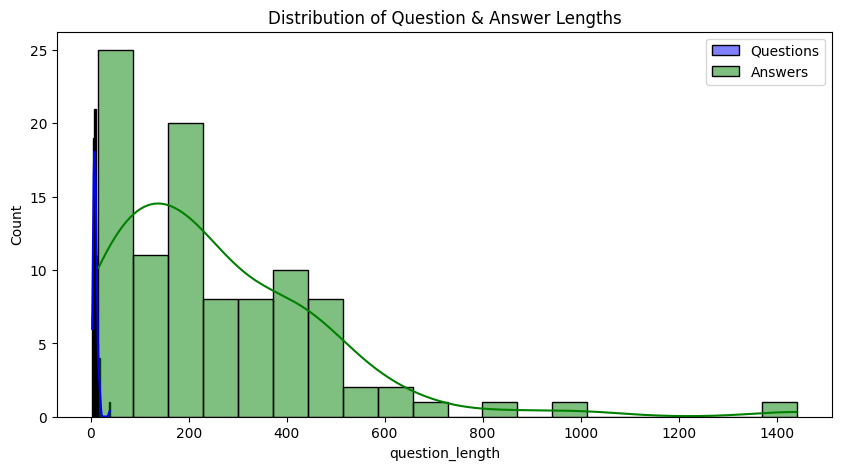

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1. Distribution of Question/Answer Lengths
df["question_length"] = df["Questions"].apply(lambda x: len(str(x).split()))
df["answer_length"] = df["Answers"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,5))
sns.histplot(df["question_length"], bins=20, kde=True, color="blue", label="Questions")
sns.histplot(df["answer_length"], bins=20, kde=True, color="green", label="Answers")
plt.legend()
plt.title("Distribution of Question & Answer Lengths")
plt.show()



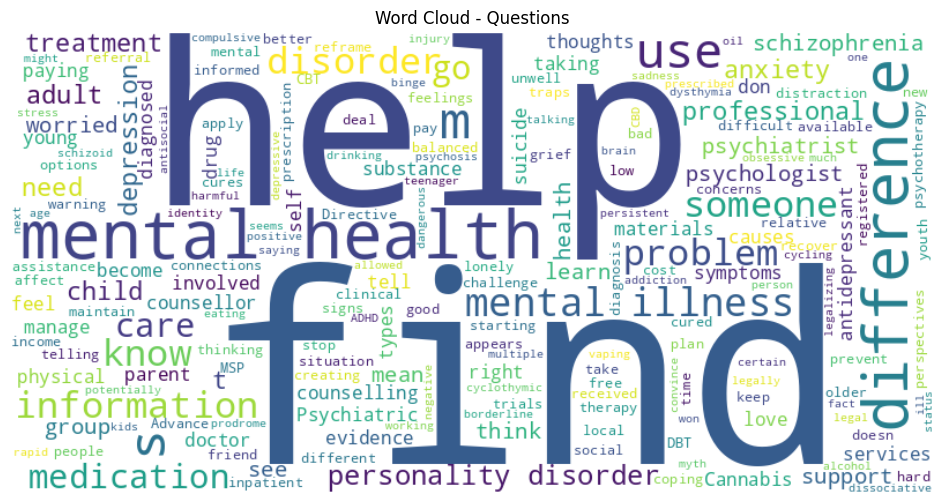

In [72]:
# 2. Word Cloud for Questions
text_questions = " ".join(df["Questions"].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_questions)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Questions")
plt.show()

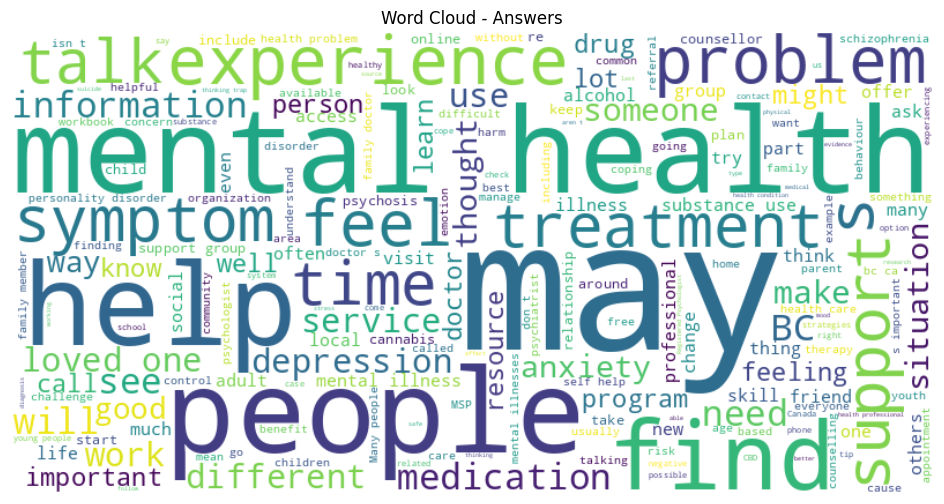

In [73]:
# 3. Word Cloud for Answers
text_answers = " ".join(df["Answers"].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_answers)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Answers")
plt.show()

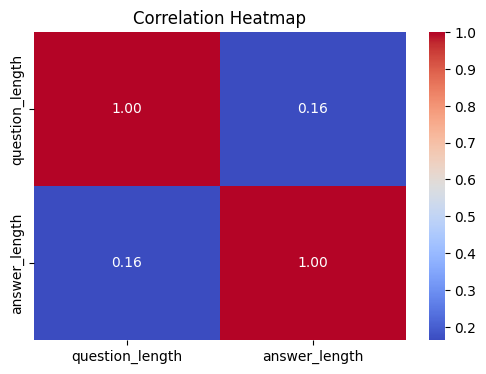

In [74]:
# 4. Correlation Heatmap of Numerical Features
numeric_features = df[["question_length", "answer_length"]]
plt.figure(figsize=(6,4))
sns.heatmap(numeric_features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# ***## 9️⃣ Define Chat Function***

In [17]:
def chat(question):
    prompt = f"question: {question} answer:"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    output = model.generate(
        input_ids,
        max_new_tokens=150,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=3
    )
    return tokenizer.decode(output[0], skip_special_tokens=True).replace("answer:", "").strip()


In [18]:
print(chat("Who does mental illness affect?	"))


People with mental illness are more likely to be affected by a mental health problem than they are by their own mental health problems. The answer to this question is that mental illness affects a wide variety of people, including people with a history of mental illness, people with disabilities, and people with developmental disabilities. People with schizophrenia and/or other mental health conditions may be more susceptible to a variety of mental health issues, such as depression, anxiety, depression, and anxiety. People who have a relationship with their parents, grandparents, and other people who may not be at risk for mental illness.


# ***## 🔟 Install Dependencies for Deployment***

In [19]:
# Install dependencies
!pip install --quiet streamlit pyngrok transformers torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.5 MB/s eta 0:00:00


# ***## 1️⃣1️⃣ Create Streamlit App***

In [66]:
%%writefile chatbot_app.py
import streamlit as st
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the fine-tuned model and tokenizer
MODEL_DIR = "/content/faq11-t5-base"
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
    model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_DIR)
except Exception as e:
    st.error(f"Error loading model or tokenizer: {e}")
    st.stop()

# Chat function
def chat(question):
    prompt = f"question: {question} answer:"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    output = model.generate(
        input_ids,
        max_new_tokens=150,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=3
    )
    return tokenizer.decode(output[0], skip_special_tokens=True).replace("answer:", "").strip()

# Streamlit UI
st.title("💬 Mental Health FAQ Chatbot")
st.write("Ask me questions about mental health and I’ll try to answer based on my fine-tuned dataset.")

user_input = st.text_input("You:", key="user_input")
if st.button("Send") and user_input:
    with st.spinner("Thinking..."):
        response = chat(user_input)
    st.write("**Bot:**", response)

Overwriting chatbot_app.py


# ***## 1️⃣2️⃣ Setup Ngrok & Run App***

In [34]:
# Install dependencies
!pip install streamlit pyngrok transformers torch datasets --quiet

In [64]:
from pyngrok import ngrok, conf

# Replace with your token
NGROK_AUTH_TOKEN = "32Qdpgmy9sPSiz0aY5DxD6YwSg8_4GHmT26Dud9dXqPXR35rD"

!ngrok config add-authtoken $NGROK_AUTH_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [60]:
!kill -9 $(pgrep ngrok)


In [68]:
!pkill streamlit
!pkill ngrok

!streamlit run chatbot_app.py &>/dev/null &
from pyngrok import ngrok
url = ngrok.connect(8501)
print("Chatbot running at:", url)

Chatbot running at: NgrokTunnel: "https://6d8f5050db71.ngrok-free.app" -> "http://localhost:8501"
